[*********************100%%**********************]  1 of 1 completed

2024-09-17 02:17:16.485839
2004-09-17 02:17:16.485839



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


-0.03957712077459465
-0.015306747345792444
-0.028608501153932032
-0.03289212235553065
-0.04260465816481556
-0.008765586726200297
-0.028564371442982656
0.029754144331583996
-0.032247009601841375
0.03720163060057234


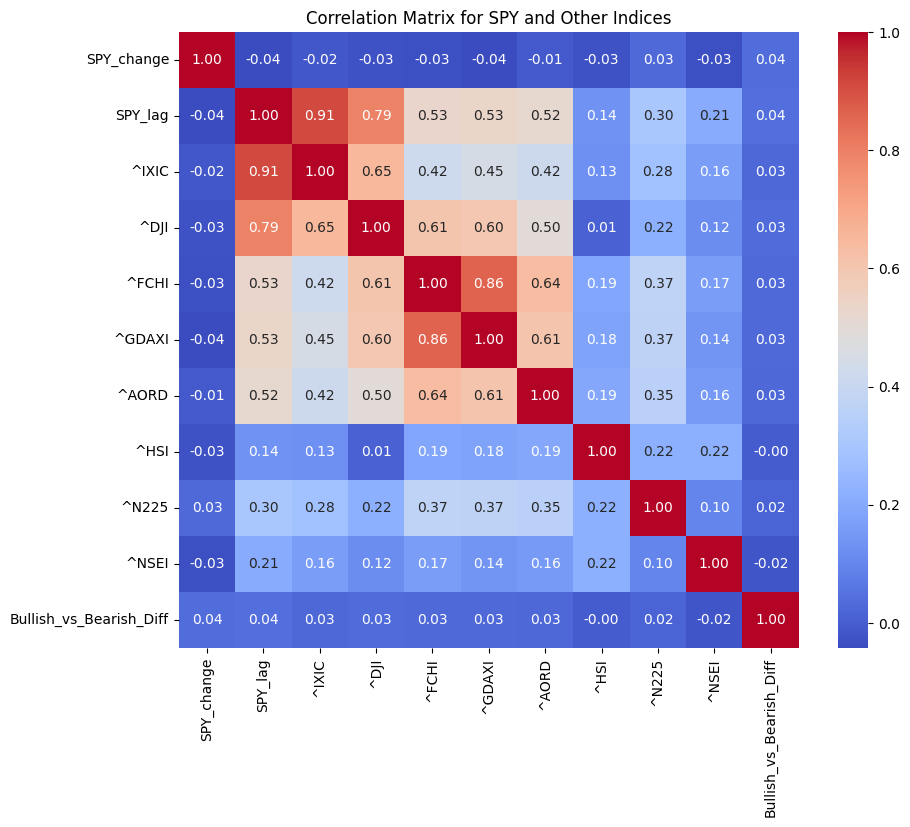

(50.292808620285776, 48.9107519325369)
(50.199109861794334, 49.37924572499414)
(50.08198641368003, 49.496369173108455)
(49.754040758959945, 49.847739517451394)
(48.98102600140548, 50.59732958538299)
(50.66760365425158, 48.79362848442258)
(49.56664324197704, 49.98828765518857)
(50.199109861794334, 49.37924572499414)
(50.36308268915437, 49.21527289763411)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3415, 7)
(794, 7)
(3415, 1)
(794, 1)
torch.Size([3405, 10, 7])
torch.Size([3405, 1])
torch.Size([784, 10, 7])
torch.Size([784, 1])
Epoch [60/60], MSE: 7.31, MAPE: 3.01
Average MSE: 22.03, Average MAPE: 1522.89


In [61]:
%run Predictions.ipynb

### Final Model Predictions on entire Dataset

In [62]:
predictions_tensors = torch.cat(predictions, dim=0)
predictions_list = predictions_tensors.flatten().tolist()

In [63]:
calc_profit_df = final_df[['Date', f'{target_stock}_change', 'Price', 'Close']].iloc[test_index:]

calc_profit_df_top10 = calc_profit_df.iloc[:10]
calc_profit_df_top10 = calc_profit_df_top10.copy()
calc_profit_df_bot10 = calc_profit_df.iloc[10:].reset_index(drop=True)

calc_profit_df_top10['Predicted_Gain'] = np.nan
calc_profit_df_bot10['Predicted_Gain'] = pd.DataFrame(predictions_list, columns=['Predicted_Gain'])
calc_profit_df = pd.concat([calc_profit_df_top10, calc_profit_df_bot10])
# print(calc_profit_df)

In [64]:
# Utilise Bollinger Bands to gauge trend and decide on whether to long or short
def calc_profit(data):
    # Applying Bollinger Bands with Exponential Moving Average
    window = 20  
    data['EMA'] = data['Price'].ewm(span=window, adjust=True).mean()
    data['STD'] = data['Price'].rolling(window=window).std()
    data['Upper_Band'] = data['EMA'] + (2 * data['STD'])
    data['Lower_Band'] = data['EMA'] - (2 * data['STD'])
    data.dropna(inplace=True, ignore_index=True)
    
    # Decide on whether to short or long the stock
    orders = []
    for _, row in data.iterrows():
        if row['Price'] > row['Upper_Band']:
            orders.append(-1)
        elif row['Price'] < row['Lower_Band']:
            orders.append(1)
        elif row['Predicted_Gain'] > 0:
            orders.append(1)
        elif row['Predicted_Gain'] < 0:
            orders.append(-1) 
    
    data['Order'] = pd.DataFrame(orders, columns=['Order'])
     
    data['Profit Per Trade'] = data[f'{target_stock}_change'] * data['Order']
    data['Cumulative Profit'] = data['Profit Per Trade'].cumsum()
    data['Hold'] = data[f'{target_stock}_change'].cumsum()
    return data

In [65]:
final_df = calc_profit(calc_profit_df)
print(final_df)

          Date  SPY_change       Price       Close  Predicted_Gain  \
0   2021-08-03    1.339996  438.440002  441.149994        0.535034   
1   2021-08-04    0.440002  439.779999  438.980011        0.477003   
2   2021-08-05    1.880005  440.220001  441.760010        0.611199   
3   2021-08-06    0.359985  442.100006  442.489990        0.487526   
4   2021-08-09    0.149994  442.459991  442.130005        0.211138   
..         ...         ...         ...         ...             ...   
770 2024-08-26   -3.690002  563.179993  560.789978        0.706936   
771 2024-08-27    1.720032  559.489990  561.559998        0.341088   
772 2024-08-28   -0.900024  561.210022  558.299988        0.677354   
773 2024-08-29    0.460022  560.309998  558.349976        0.278998   
774 2024-08-30   -0.300049  560.770020  563.679993        0.720562   

            EMA        STD  Upper_Band  Lower_Band  Order  Profit Per Trade  \
0    436.753821   4.397731  445.549283  427.958359      1          1.339996   
1

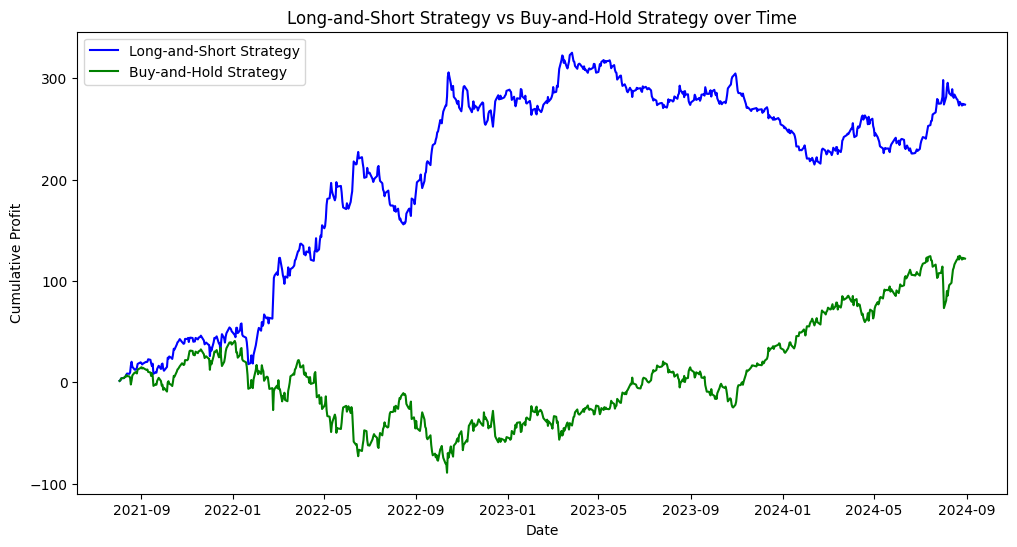

In [66]:
plt.figure(figsize=(12, 6))

plt.plot(final_df['Date'], final_df['Cumulative Profit'], label='Long-and-Short Strategy', color='blue')
plt.plot(final_df['Date'], final_df['Hold'], label='Buy-and-Hold Strategy', color='green')
# Plotting Price, Upper_Band and Lower_Band
# plt.plot(final_df['Date'], final_df['Upper_Band'], label='Upper_Band', color='red')
# plt.plot(final_df['Date'], final_df['Lower_Band'], label='Lower_Band', color='red')
# plt.plot(final_df['Date'], final_df['Price'], label='Price', color='black')

plt.title('Long-and-Short Strategy vs Buy-and-Hold Strategy over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

### BackTest Strategy

In [67]:
def calc_sharpe_ratio(data, risk_free_rate):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Return'] =  np.log(data['Wealth']) - np.log(data['Wealth'].shift(1))
    daily_return = data['Return'].dropna()
    excess_return = daily_return - risk_free_rate / 252
    daily_sharpe = excess_return.mean() / excess_return.std(ddof=1)
    yearly_sharpe = (252**0.5) * daily_sharpe
    return daily_sharpe, yearly_sharpe

def calc_max_drawdown(data):
    data['Wealth'] = data['Cumulative Profit'] + data.loc[data.index[0], 'Price']
    data['Peak'] = data['Wealth'].cummax()
    data['Drawdown'] = (data['Peak'] - data['Wealth']) / data['Peak']
    max_drawdown = data['Drawdown'].max()
    return max_drawdown

In [68]:
calc_sharpe_ratio(final_df, 0.05)

(0.055514283005401496, 0.8812619222661104)

In [69]:
calc_max_drawdown(final_df)

0.14445676036997443

In [71]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'model_state_dict.pth')